# General Imports

In [1]:
%config IPCompleter.use_jedi=False

import os
import tensorflow as tf
import tensorflow
from tensorflow import keras
import numpy as np
import pathlib
from functools import partial
import pandas as pd
import time
from platform import python_version
from datetime import datetime
from glob import glob
from helper import *

%matplotlib inline

# # specifically working for dgx not on local
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"
# os.environ['TF_GPU_THREAD_MODE'] = 'gpu_private'

print("== Version check ==")
print("python_version: ", python_version())
print("TensorFlow version: {}".format(tf.__version__))
print("Keras version: {}".format(keras.__version__))

== Version check ==
python_version:  3.8.10
TensorFlow version: 2.4.0
Keras version: 2.4.0


# Import models

In [2]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# Tensorflow config

In [3]:
set_tensorflow_config()

== TensorFlow Config options set ==

This process will now utilize 0.7 GPU Memeory Fraction


# Dataset

In [4]:
abs_dataset_path = '/home/ubuntu/mount/Notebooks/abg/anuj_ws/image-datasets/cats_vs_dogs_redux/original/train/'

In [5]:
data_dir = pathlib.Path(abs_dataset_path)

In [6]:
list_ds_files = tf.data.Dataset.list_files(str(data_dir)+'/*/*', shuffle=False)

In [7]:
print("Total number of files loaded: {}".format(cardinality_check(list_ds_files)))

Total number of files loaded: 25000


In [8]:
train_ds, validation_ds, test_ds = split_dataset(list_ds_files)

# Image Count, class names, number of classes

In [9]:
# image_count = len(list(data_dir.glob('*/*.jpg')))
# print(image_count)

# tf way 
# class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))

# simple way?
CLASS_NAMES =  sorted(os.listdir(data_dir))
print(CLASS_NAMES)

NUM_CLASSES = len(CLASS_NAMES)

['cats', 'dogs']


# Train, validation, and test set cardinality

In [10]:
NUM_TRAIN_FILES = cardinality_check(train_ds)
NUM_VALIDATION_FILES = cardinality_check(validation_ds)
NUM_TEST_FILES = cardinality_check(test_ds)

print("Number of training files: {}".format(NUM_TRAIN_FILES))
print("Number of validation files: {}".format(NUM_VALIDATION_FILES))
print("Number of test files: {}".format(NUM_TEST_FILES))

Number of training files: 15000
Number of validation files: 7500
Number of test files: 2500


# Transfer Learning Hyperparameters

In [11]:
BATCH_SIZE = 8
EPOCHS = 1
TL_LEARNING_RATE = 0.001
DROPOUT_RATE = 0.4

# ETL Pipeline parameters

In [12]:
TRAIN_STEP_PER_EPOCHS = NUM_TRAIN_FILES/BATCH_SIZE
VALIDATION_STEPS_PER_EPOCHS = NUM_VALIDATION_FILES/BATCH_SIZE
TEST_STEPS_PER_EPOCHS = NUM_TEST_FILES/BATCH_SIZE

print("step size for training: ", TRAIN_STEP_PER_EPOCHS)
print("step size for validation: ", VALIDATION_STEPS_PER_EPOCHS)
print("step size for test: ", TEST_STEPS_PER_EPOCHS)

ONE_HOT = True
EXPERIMENT_NAME = 'cats_vs_dogs_model'

# sparse_categorical, binary
# CLASS_TYPE = 'sparse_categorical'
CLASS_TYPE = None

if NUM_CLASSES < 2:
    ONE_HOT = False
    CLASSIFIER = 'sigmoid'
    CLASS_TYPE = 'binary' 
else:
    CLASSIFIER = 'softmax'
    if not ONE_HOT:
        CLASS_TYPE = 'sparse_categorical'


IMG_SIZE = 224
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

step size for training:  1875.0
step size for validation:  937.5
step size for test:  312.5


# Performance parameters

In [13]:
AUTOTUNE = tf.data.AUTOTUNE
DATA_BUFFER_SIZE = 20000
INTERLEAVE_CYCLE_LENGTH = 4
SHUFFLE_BUFFER_SIZE = 1000

## train

In [14]:
train_ds = data_loader(train_ds, 
                       parse_image, 
                       True, 
                       ONE_HOT, 
                       CLASS_NAMES, 
                       NUM_CLASSES, 
                       IMG_SIZE, 
                       AUTOTUNE, 
                       INTERLEAVE_CYCLE_LENGTH,
                       BATCH_SIZE,
                       preprocess_input,
                       None,
                       True,
                       
                      )

=== Applying Data Augmentation on this dataset ===
=== Applying Data Shuffle on this dataset with shuffle buffer size = 1000 ===


In [15]:
train_ds

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 2)), types: (tf.float32, tf.float32)>

## validation

In [16]:
validation_ds = data_loader(validation_ds, 
                       parse_image, 
                       False, 
                       ONE_HOT, 
                       CLASS_NAMES, 
                       NUM_CLASSES, 
                       IMG_SIZE, 
                       AUTOTUNE, 
                       INTERLEAVE_CYCLE_LENGTH,
                       BATCH_SIZE,
                       preprocess_input,
                       None,
                       False,
                       
                      )

In [17]:
validation_ds

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 2)), types: (tf.float32, tf.float32)>

## test

In [18]:
test_ds = data_loader(test_ds, 
                       parse_image, 
                       False, 
                       ONE_HOT, 
                       CLASS_NAMES, 
                       NUM_CLASSES, 
                       IMG_SIZE, 
                       AUTOTUNE, 
                       INTERLEAVE_CYCLE_LENGTH,
                       BATCH_SIZE,
                       preprocess_input,
                       None,
                       False,
                       
                      )

In [19]:
test_ds

<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 2)), types: (tf.float32, tf.float32)>

# Visualize dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


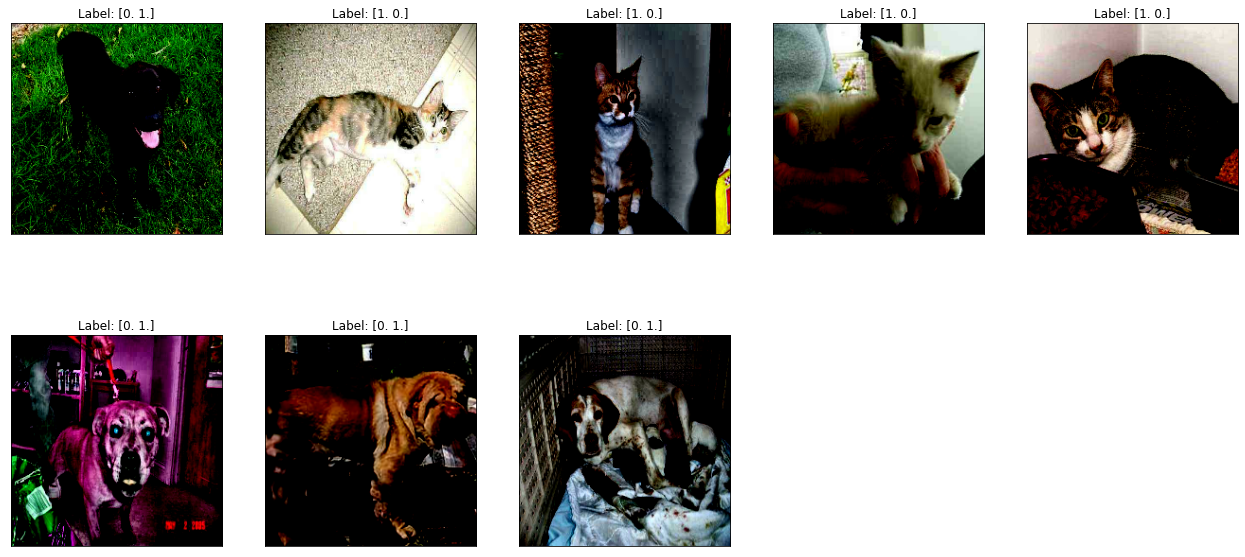

In [20]:
view_image(train_ds.take(2))

# Build model

In [21]:
base_model = MobileNetV2(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=INPUT_SHAPE,
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

In [22]:
# Create new model on top
inputs = keras.Input(shape=INPUT_SHAPE)
# x = data_augmentation(inputs)  # Apply random data augmentation

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
# x = base_model(x, training=False)
# x = preprocess_input(inputs)
x = base_model(inputs, training=False)
# from here till the classifier layer, it is all experimental 
# as to how many layers we think would be required that can help build a better model for our dataset

x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.5)(x)  # Regularize with dropout
x = keras.layers.Dense(1024, activation='relu',name='fc-1')(x)
# x = keras.layers.Dropout(0.2)(x)
#x = keras.layers.Dense(256, activation='relu',name='fc-2')(x)
#x = keras.layers.Dropout(0.5)(x)

outputs = keras.layers.Dense(NUM_CLASSES, activation=CLASSIFIER)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
fc-1 (Dense)                 (None, 1024)              1311744   
_________________________________________________________________
dense (Dense)                (None, 2)                 2050      
Total params: 3,571,778
Trainable params: 1,313,794
Non-trainable params: 2,257,984
___________________________________________

# Loss and metrics

In [23]:
metrics, loss = get_loss_and_metrics(ONE_HOT, CLASS_TYPE)

# Compile model

In [24]:
optimizer = tensorflow.keras.optimizers.Adam()
model.compile(loss=loss, 
              optimizer=optimizer, 
              metrics = metrics
             )

# Model Training

In [25]:
start_time= time.perf_counter()

history = model.fit(
            train_ds,
            steps_per_epoch = TRAIN_STEP_PER_EPOCHS,
            validation_data = validation_ds,
            validation_steps = VALIDATION_STEPS_PER_EPOCHS,
            
            epochs=EPOCHS
)

end_time = time.perf_counter()

print(end_time-start_time)

1875/1875 [==============================] - 97s 46ms/step - loss: 0.1338 - categorical_crossentropy: 0.1338 - val_loss: 0.9946 - val_categorical_crossentropy: 0.9946
96.90869747847319


# References
1. https://stackoverflow.com/questions/53514495/what-does-batch-repeat-and-shuffle-do-with-tensorflow-dataset
2. https://cs230.stanford.edu/blog/datapipeline/#building-an-image-data-pipeline
3. https://towardsdatascience.com/what-is-the-best-input-pipeline-to-train-image-classification-models-with-tf-keras-eb3fe26d3cc5